Replicate standard normal distribution with COS method:

$$f_{\mathcal{N}(0,1)}(y) = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}y^2}, \quad \phi_{\mathcal{N}(0,1)}(u) = e^{-\frac{1}{2}u^2}$$

In [3]:
import numpy as np


def calc_phi(u):
    return np.exp(-0.5 * u**2)

def calc_Fk(a, b, k):
    return 2 / (b - a) * np.real(calc_phi(k*np.pi / (b-a)) * np.exp(-1j * (k*a*np.pi) / (b-a)))

def calc_f_hat(y, a, b, k):
    result = 0
    for i in range(k):
        if i==0:
            result += 0.5 * calc_Fk(a, b, i) * np.cos(i * np.pi * (y - a) / (b - a))
        else:
            result += calc_Fk(a, b, i) * np.cos(i * np.pi * (y - a) / (b - a))
    return result

def calc_f(y):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-0.5 * y**2)

In [25]:
a = -10
b = 10

lower_bound = -5
upper_bound = 5
dx = 0.01
k1 = 4
k2 = 8
k3 = 16
k4 = 32
k5 = 64

X = np.arange(lower_bound, upper_bound+dx, dx)
f = []
f_hat1, f_hat2, f_hat3, f_hat4, f_hat5 = [], [], [], [], []

for x in X:
    f.append(calc_f(x))
    f_hat1.append(calc_f_hat(x, a, b, k1))
    f_hat2.append(calc_f_hat(x, a, b, k2))
    f_hat3.append(calc_f_hat(x, a, b, k3))
    f_hat4.append(calc_f_hat(x, a, b, k4))
    f_hat5.append(calc_f_hat(x, a, b, k5))
    
f = np.array(f)
f_hat1 = np.array(f_hat1)
f_hat2 = np.array(f_hat2)
f_hat3 = np.array(f_hat3)
f_hat4 = np.array(f_hat4)
f_hat5 = np.array(f_hat5)

Plot distribution with varying values of $N$ (number of terms in the Fourier cosine expansion).

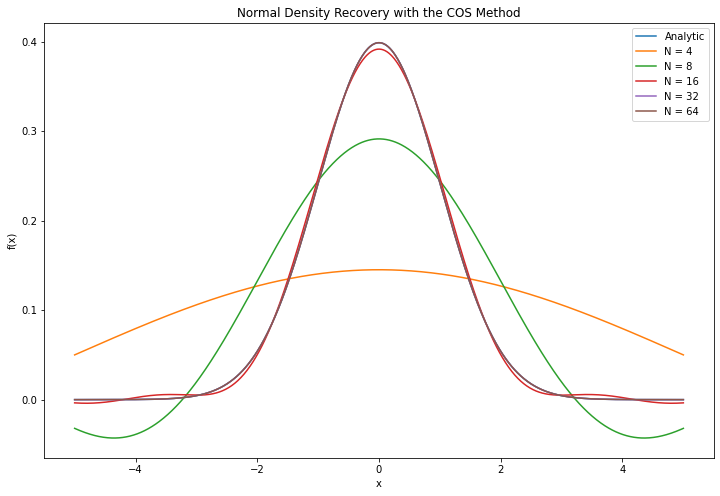

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(X, f)
plt.plot(X, f_hat1)
plt.plot(X, f_hat2)
plt.plot(X, f_hat3)
plt.plot(X, f_hat4)
plt.plot(X, f_hat5)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Normal Density Recovery with the COS Method')
plt.legend(['Analytic', 'N = 4', 'N = 8', 'N = 16', 'N = 32', 'N = 64'])

In [27]:
# Calculate max errors
print('Max Error for N = 4:', np.max(np.abs(f - f_hat1)))
print('Max Error for N = 8:', np.max(np.abs(f - f_hat2)))
print('Max Error for N = 16:', np.max(np.abs(f - f_hat3)))
print('Max Error for N = 32:', np.max(np.abs(f - f_hat4)))
print('Max Error for N = 64:', np.max(np.abs(f - f_hat5)))

Max Error for N = 4: 0.25375729966450533
Max Error for N = 8: 0.10753236532743599
Max Error for N = 16: 0.0071750529323375
Max Error for N = 32: 4.0376051230195387e-07
Max Error for N = 64: 3.885780586188048e-16


# Geometric Brownian Motion

In [87]:
import numpy as np
from scipy.stats import norm

class GeometricBrownianCOS:
    def __init__(self, S0, r, q, T, sigma, N, strikes):
        self.S0, self.r, self.q, self.T, self.sigma, self.N = S0, r, q, T, sigma, N
        self.x0 = np.log(S0 / strikes)
        self.strikes = strikes
        
        self.a, self.b = self.get_interval(T)
    
    def get_interval(self, tau, L=10):
        return -L * np.sqrt(tau), L * np.sqrt(tau)
    
    def chi(self, c, d, k):
        first_term = np.cos(k * np.pi * (d - self.a) / (self.b - self.a)) * np.exp(d)
        second_term = -np.cos(k * np.pi * (c - self.a) / (self.b - self.a)) * np.exp(c)
        third_term = (k * np.pi) / (self.b - self.a) * np.sin(k * np.pi \
                                                                   * (d - self.a) / (self.b - self.a)) * np.exp(d)
        fourth_term = - (k * np.pi) / (self.b - self.a) \
                                * np.sin(k * np.pi * (c - self.a) / (self.b - self.a)) * np.exp(c)

        return 1 / (1 + ((k * np.pi) / (self.b - self.a))**2) * (first_term + second_term + third_term + fourth_term)

    def psi(self, c, d, k):
        if k == 0:
            return d - c

        first_term = np.sin(k * np.pi * (d - self.a) / (self.b - self.a))
        second_term = -np.sin(k * np.pi * (c - self.a) / (self.b - self.a))

        return (self.b - self.a) / (k * np.pi) * (first_term + second_term)

    def H(self, k, option_type: str):
        if option_type.upper()=='CALL':
            return 2 / (self.b - self.a) * self.strikes * (self.chi(c=0, d=self.b, k=k) - self.psi(c=0, d=self.b, k=k))
        elif option_type.upper()=='PUT':
            return 2 / (self.b - self.a) * self.strikes * (-self.chi(c=self.a, d=0, k=k) + self.psi(c=self.a, d=0, k=k))
        
        return 0

    def mu(self):
        return self.r - 0.5 * self.sigma**2 - self.q
    
    def char_func(self, u):
        return np.exp(1j * u * self.mu() * self.T - 0.5 * self.sigma**2 * u**2 * self.T)
    
    def calculate_option_price(self, option_type: str):
        result = 0
        
        for k in range(self.N):
            if k==0:
                result += 0.5 * np.real(
                    self.char_func(k * np.pi / (self.b - self.a)) *\
                    np.exp(1j * k * np.pi * (self.x0 - self.a) / (self.b - self.a))) * self.H(k, option_type)
            else:
                result += np.real(
                    self.char_func(k * np.pi / (self.b - self.a)) *\
                    np.exp(1j * k * np.pi * (self.x0 - self.a) / (self.b - self.a))) * self.H(k, option_type)
                
        return np.exp(-self.r * self.T) * result
    
class BlackScholesPricer:
    def __init__(self, S0, r, sigma, T, K):
        self.S0, self.r, self.sigma, self.T, self.K = S0, r, sigma, T, K
        self.d1 = self.calc_d1()
        self.d2 = self.d1 - self.sigma * np.sqrt(self.T)
        self.call_price = self.calc_call_price()
        #self.put_price = self.calc_put_price()
        #self.call_delta = self.calc_call_delta()
        #self.put_delta = self.calc_put_delta()
        
    def calc_d1(self):
        num = np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma**2) * (self.T)
        denom = self.sigma * np.sqrt(self.T)
        return num / denom
    
    def calc_call_price(self):
        return self.S0 * norm.cdf(self.d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2)
    
    def calc_put_price(self):
        return self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2) - self.S0 * norm.cdf(-self.d1)
    
    def calc_call_delta(self):
        return norm.cdf(self.d1)
    
    def calc_put_delta(self):
        return norm.cdf(self.d1) - 1

In [91]:
strikes = np.array([80.0, 100.0, 120.0])
S0 = 100
r = 0.1
q = 0
T = 0.1
sigma = 0.25
N = 64  # how many terms to include

In [95]:
import time

start = time.time()
cos_model = GeometricBrownianCOS(S0, r, q, T, sigma, N, strikes)
print(cos_model.calculate_option_price('call'))
end = time.time()

print(end - start)

[20.79922618  3.65996807  0.04457746]
0.006981611251831055


In [96]:
start = time.time()
print(BlackScholesPricer(S0, r, sigma, T, strikes).call_price)
end = time.time()

print(end - start)

[20.79922631  3.65996845  0.04457781]
0.000997304916381836
